In [1]:
import relational_image_generation_evaluation as rige

In [2]:
evaluator = rige.Evaluator('ViT-L/14')
dataloader_one = rige.get_one_edge_dataloader(testonly=True)
dataloader_two = rige.get_two_edge_dataloader(testonly=True)
dataloader_full = rige.get_full_graph_dataloader(testonly=True)
print("len(dataloader_one):", len(dataloader_one))
print("len(dataloader_two):", len(dataloader_two))

Using device cuda:1 for evaluation.
Using text embeddings as input to the model.
Loading filtered test graphs...
Finished loading filtered test graphs
Generating one edge graphs...


100%|██████████| 100/100 [00:00<00:00, 1056.99it/s]

Finished generating one edge graphs
Loading filtered test graphs...
Finished loading filtered test graphs
Generating two edge graphs...



100%|██████████| 100/100 [00:00<00:00, 891.91it/s]


Finished generating two edge graphs
Loading filtered test graphs...
Finished loading filtered test graphs
len(dataloader_one): 837
len(dataloader_two): 1076


In [3]:
from PIL import Image
images = []
graphs = []
for i in range(10):
    graph = next(iter(dataloader_one))[0]
    image_id = graph.image_id
    IMAGE_DIR = '/local/home/jthomm/GraphCLIP/datasets/visual_genome/raw/VG/'
    image = Image.open(IMAGE_DIR + str(image_id) + '.jpg')
    images.append(image)
    graphs.append(graph)

In [4]:
scores = evaluator(images,graphs)
print(scores)
print(scores.keys())

{'rel_scores': [0.9963749051094055, 0.9753934741020203, 0.9214745163917542, 0.9958992600440979, 0.8125936388969421, 0.7544750571250916, 0.4216979146003723, 0.9317278861999512, 0.9186421036720276, 0.012344365939497948], 'attr_scores': [0.15855653584003448, 0.7651040554046631, 0.9766125679016113, 0.34666815400123596, 0.18600665032863617, 'noattributes', 0.11902481317520142, 0.25954243540763855, 0.3700721263885498, 0.07474261522293091]}
dict_keys(['rel_scores', 'attr_scores'])


In [5]:
images = []
graphs = []
for i in range(10):
    graph = next(iter(dataloader_two))[0]
    assert len(graph.edges) == 2, f"Graph does not have two edges: {graph.edges}"
    image_id = graph.image_id
    IMAGE_DIR = '/local/home/jthomm/GraphCLIP/datasets/visual_genome/raw/VG/'
    image = Image.open(IMAGE_DIR + str(image_id) + '.jpg')
    # image = image.convert('RGB')
    images.append(image)
    graphs.append(graph)

In [6]:
scores = evaluator(images,graphs)
print(scores)
print(scores.keys())

{'rel_scores': [0.9885056614875793, 0.9839268326759338, 8.248157428170089e-07, 0.9772341847419739, 0.9576905965805054, 0.523443341255188, 0.8659615516662598, 0.8880363702774048, 0.8659616112709045, 0.8461143970489502], 'attr_scores': [0.5559964179992676, 'noattributes', 0.24270299077033997, 'noattributes', 0.5323565006256104, 0.6055250763893127, 0.40389275550842285, 0.5705788731575012, 0.40389296412467957, 0.26415884494781494]}
dict_keys(['rel_scores', 'attr_scores'])


In [7]:
from PIL import Image

images_orig = []
graphs_orig = []
images_adv = []
graphs_adv = []
for i in range(300):
    graph = next(iter(dataloader_one))[0]
    assert len(graph.edges) == 1, f"Graph does not have one edge: {graph.edges}"
    image_id = graph.image_id
    IMAGE_DIR = '/local/home/jthomm/GraphCLIP/datasets/visual_genome/raw/VG/'
    image_orig = Image.open(IMAGE_DIR + str(image_id) + '.jpg')
    image_adv = Image.open(IMAGE_DIR + str(image_id) + '.jpg')
    # image = image.convert('RGB')
    images_orig.append(image_orig)
    graphs_orig.append(graph)
    graph_adv = rige.copy_graph(graph)
    # flip the attributes of the two nodes in the graph
    [n1,n2] = list(graph_adv.nodes)[0:2]
    graph_adv.nodes[n1]['attributes'], graph_adv.nodes[n2]['attributes'] = graph_adv.nodes[n2]['attributes'], graph_adv.nodes[n1]['attributes']
    images_adv.append(image_adv)
    graphs_adv.append(graph_adv)
scores_orig = evaluator(images_orig,graphs_orig)
scores_adv = evaluator(images_adv,graphs_adv)
print(scores_orig['attr_scores'])
print(scores_adv['attr_scores'])

['noattributes', 0.15855655074119568, 'noattributes', 0.3813652992248535, 'noattributes', 'noattributes', 0.4027596414089203, 0.5549305081367493, 'noattributes', 'noattributes', 0.5059268474578857, 0.34000304341316223, 0.42295584082603455, 0.4038931429386139, 'noattributes', 0.49560895562171936, 0.0864562839269638, 'noattributes', 0.6534953117370605, 0.23712939023971558, 0.028290022164583206, 0.4048355519771576, 'noattributes', 0.40389305353164673, 0.5688793063163757, 'noattributes', 0.568879246711731, 0.714468777179718, 0.29095205664634705, 0.16564823687076569, 0.28223586082458496, 0.5526719689369202, 0.0007241009152494371, 'noattributes', 'noattributes', 'noattributes', 0.06281307339668274, 'noattributes', 0.0477331206202507, 0.13036774098873138, 'noattributes', 0.35067781805992126, 'noattributes', 0.04443687945604324, 0.525521993637085, 0.17989161610603333, 'noattributes', 0.7651039361953735, 0.3132937550544739, 'noattributes', 0.6558380722999573, 0.9041731357574463, 0.2717391848564

In [8]:
# print how often the model was more confident in the good graph
n_good = 0
n_bad = 0
for orig,adv in zip(scores_orig['attr_scores'],scores_adv['attr_scores']):
    if orig == 'noattributes':
        continue
    if orig == adv:
        n_good += 0.5
        print("warning, this is unlikely to happen")
    elif orig>adv:
        n_good += 1
    else:
        n_bad += 1

print(f"n_correct: {n_good}, n_incorrect: {n_bad}, accuracy: {n_good/(n_good+n_bad)}")

n_correct: 185, n_incorrect: 15, accuracy: 0.925


# Evaluate on Robert's dataset

In [4]:
from PIL import Image
ROBERT_DATASET_PATH = '/local/home/jthomm/GraphCLIP/datasets/visual_genome/raw/realistic_adversarial_attributes_gt_accepted_pruned.json'
JONATHAN_DATASET_V1_PATH = '/local/home/jthomm/GraphCLIP/datasets/visual_genome/processed/ra_selections_curated_adversarial.pt'
JONATHAN_DATASET_V2_PATH = '/local/home/jthomm/GraphCLIP/datasets/visual_genome/processed/ra_selections_curated_adversarial2.pt'
IMAGE_DIR = '/local/home/jthomm/GraphCLIP/datasets/visual_genome/raw/'
EVALUATOR_NAME = 'ViT-L/14'

def get_image(image_id: int):
    try:
        image = Image.open(IMAGE_DIR + "VG/" + str(image_id) + '.jpg')
        return image
    except:
        pass
    try:
        image = Image.open(IMAGE_DIR + "VG_100K/" + str(image_id) + '.jpg')
        return image
    except:
        pass
    try:
        image = Image.open(IMAGE_DIR + "VG_100K_2/" + str(image_id) + '.jpg')
        return image
    except:
        raise Exception(f"Could not find image with id {image_id}")

In [5]:
import relational_image_generation_evaluation as rige

In [6]:
import json
with open(ROBERT_DATASET_PATH, 'r') as f:
    data = json.load(f)
    print(len(data))

100


In [7]:
import networkx as nx
graphs = []
for sample in data:
    graph = nx.DiGraph()
    graph.image_id = sample['image_id']
    obj1_name = sample['objects'][0]['names'][0]
    obj1_id = sample['objects'][0]['object_id']
    obj2_name = sample['objects'][1]['names'][0]
    obj2_id = sample['objects'][1]['object_id']
    obj1_attrs = sample['objects'][0]['attributes']
    obj2_attrs = sample['objects'][1]['attributes']
    assert obj1_name in rige.FILTERED_OBJECTS, f"obj1_attrs: {obj1_attrs}"
    assert obj2_name in rige.FILTERED_OBJECTS, f"obj2_attrs: {obj2_attrs}"
    for attr in obj1_attrs:
        assert attr in rige.FILTERED_ATTRIBUTES, f"obj1_attrs: {obj1_attrs}"
    for attr in obj2_attrs:
        assert attr in rige.FILTERED_ATTRIBUTES, f"obj2_attrs: {obj2_attrs}"
    # add nodes with attributes and labels
    graph.labels = {}
    graph.add_node(obj1_id, attributes=obj1_attrs, name=obj1_name)
    graph.labels[obj1_id] = obj1_name
    graph.add_node(obj2_id, attributes=obj2_attrs, name=obj2_name)
    graph.labels[obj2_id] = obj2_name
    graphs.append(graph)

In [8]:
evaluator = rige.Evaluator(EVALUATOR_NAME)

Using device cuda:1 for evaluation.
Using text embeddings as input to the model.


In [9]:
from PIL import Image

images_orig = []
graphs_orig = []
images_adv = []
graphs_adv = []
for graph in graphs:
    image_id = graph.image_id
    image_orig = get_image(image_id)
    image_adv = get_image(image_id)
    # image = image.convert('RGB')
    images_orig.append(image_orig)
    graphs_orig.append(graph)
    graph_adv = rige.copy_graph(graph)
    # flip the attributes of the two nodes in the graph
    [n1,n2] = list(graph_adv.nodes)[0:2]
    graph_adv.nodes[n1]['attributes'], graph_adv.nodes[n2]['attributes'] = graph_adv.nodes[n2]['attributes'], graph_adv.nodes[n1]['attributes']
    images_adv.append(image_adv)
    graphs_adv.append(graph_adv)
scores_orig = evaluator(images_orig,graphs_orig)
scores_adv = evaluator(images_adv,graphs_adv)
try:
    print(scores_orig['attr_scores'])
    print(scores_adv['attr_scores'])
except:
    print(scores_orig['overall_scores'])
    print(scores_adv['overall_scores'])

[0.5067169070243835, 0.5126994252204895, 0.014939866960048676, 0.05341815948486328, 0.35333967208862305, 0.5326797366142273, 0.5962044596672058, 0.43216270208358765, 0.8438870906829834, 0.19870734214782715, 0.40836358070373535, 0.30747610330581665, 0.014071582816541195, 0.3022443950176239, 0.3189970850944519, 0.8700500726699829, 0.45898908376693726, 0.48020410537719727, 0.46609851717948914, 0.3996104300022125, 0.8092801570892334, 0.13676047325134277, 0.9554259777069092, 0.34916552901268005, 0.1810743510723114, 0.4731653034687042, 0.2685999870300293, 0.4498291313648224, 0.27271419763565063, 0.15753063559532166, 0.45829343795776367, 0.03702370449900627, 0.2376910150051117, 0.2652689516544342, 0.09565064311027527, 0.22291749715805054, 0.010786307044327259, 0.8500231504440308, 0.0007952172309160233, 0.8031558990478516, 0.6283318996429443, 0.42809075117111206, 0.5244410634040833, 0.8952538371086121, 0.6321172118186951, 0.34471774101257324, 0.24998705089092255, 0.3405316174030304, 0.21549296

In [10]:
# print how often the model was more confident in the good graph
n_good = 0
n_bad = 0
wrong_indices = []
try:
    orig_adv_pairs = zip(scores_orig['attr_scores'],scores_adv['attr_scores'])
except:
    orig_adv_pairs = zip(scores_orig['overall_scores'],scores_adv['overall_scores'])
for i,(orig,adv) in enumerate(orig_adv_pairs):
    if orig == 'noattributes':
        continue
    if orig == adv:
        n_good += 0.5
        print("warning, this is unlikely to happen")
    elif orig>adv:
        n_good += 1
    else:
        n_bad += 1
        wrong_indices.append(i)

print(f"n_correct: {n_good}, n_incorrect: {n_bad}, accuracy: {n_good/(n_good+n_bad)}")

n_correct: 91, n_incorrect: 9, accuracy: 0.91


## Show the wrongly predicted ones
(running generates lot of output)

150476
bus  with attributes:  ['white']
truck  with attributes:  ['purple']
0.19870734214782715
0.27337372303009033


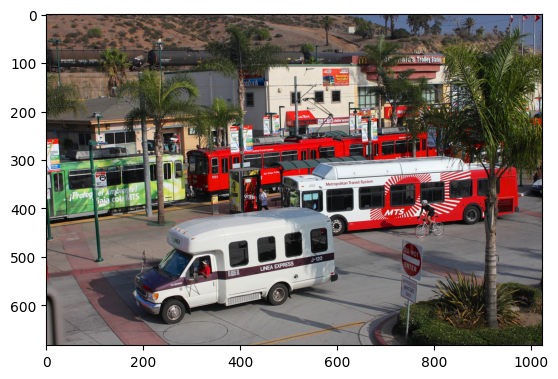

150502
desk  with attributes:  ['black']
chair  with attributes:  ['orange']
0.014071582816541195
0.040557559579610825


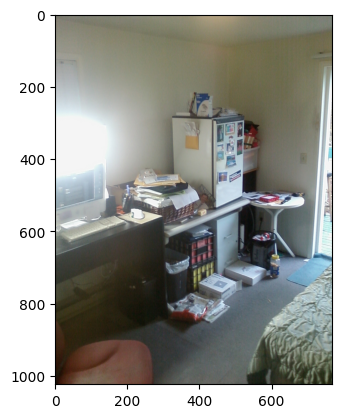

1593095
man  with attributes:  ['brown']
basket  with attributes:  ['large']
0.13676047325134277
0.2722724378108978


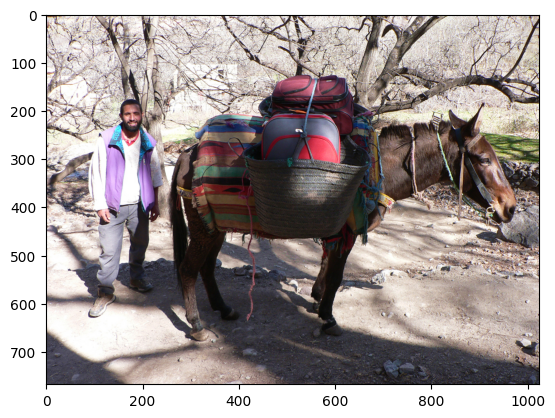

2411306
desk  with attributes:  ['wooden']
seat  with attributes:  ['striped']
0.15753063559532166
0.40125808119773865


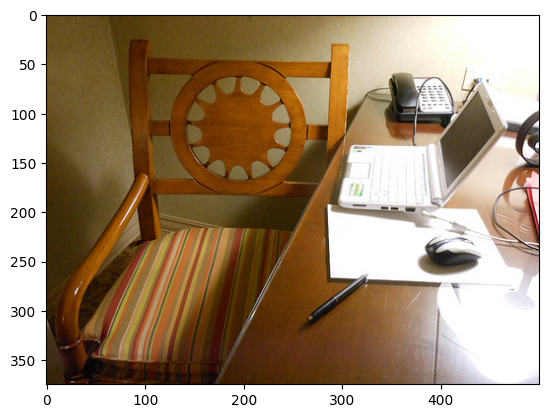

2410959
cake  with attributes:  ['round']
plate  with attributes:  ['gray']
0.010786307044327259
0.0211170744150877


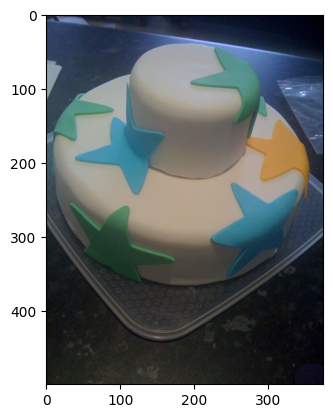

2410959
plate  with attributes:  ['gray']
floor  with attributes:  ['wood']
0.0007952172309160233
0.018160179257392883


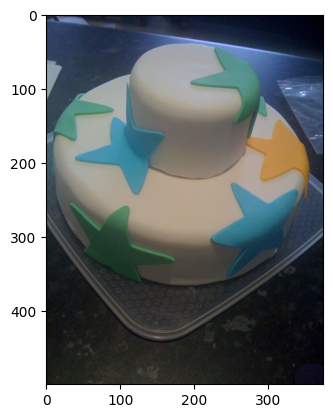

2
sidewalk  with attributes:  ['white']
pole  with attributes:  ['brown']
0.011273895390331745
0.04536864161491394


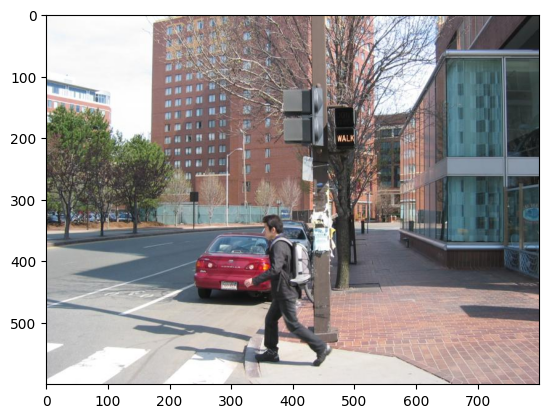

4
frame  with attributes:  ['wooden']
table  with attributes:  ['metal']
0.06062520295381546
0.14751136302947998


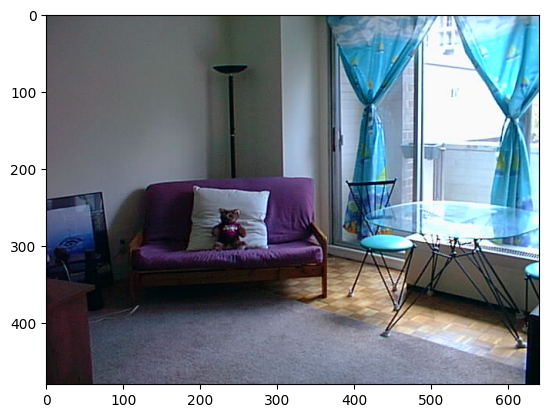

2395832
sky  with attributes:  ['bright']
bench  with attributes:  ['blue']
0.06140539050102234
0.3902828097343445


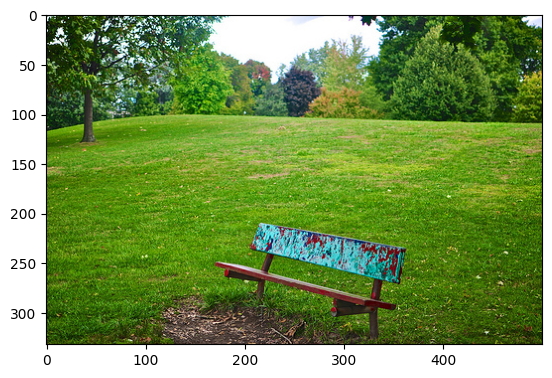

In [11]:
import matplotlib.pyplot as plt
for i,graph in enumerate(graphs):
    if i in wrong_indices:
        print(graph.image_id)
        obj1_name = graph.nodes[list(graph.nodes)[0]]['name']
        obj2_name = graph.nodes[list(graph.nodes)[1]]['name']
        print(obj1_name, " with attributes: ", graph.nodes[list(graph.nodes)[0]]['attributes'])
        print(obj2_name, " with attributes: ", graph.nodes[list(graph.nodes)[1]]['attributes'])
        try:
            print(scores_orig['attr_scores'][i])
            print(scores_adv['attr_scores'][i])
        except:
            print(scores_orig['overall_scores'][i])
            print(scores_adv['overall_scores'][i])
        # plot the image
        image = get_image(graph.image_id)
        plt.imshow(image)
        plt.show()

# Evaluate on Jonathan's Dataset
run Robert's first, the imports are not done again

In [13]:
import torch
# copied from somewhere else
def get_realistic_graphs_dataset_rel(version):
    if version == 'v1':
        curated_adversarialt = torch.load(JONATHAN_DATASET_V1_PATH) # a dict with image_id as key and a graph and the adversarial perturbations as value
    elif version == 'v2':
        curated_adversarialt = torch.load(JONATHAN_DATASET_V2_PATH)
    else:
        raise ValueError(f"version {version} not recognized")
    # the format of the dict is {image_id: [(original_graph,graph_edge,adv_predicate), ...]}
    # we return a list of tuples (graphs, adv_graph, adv_edge, adv_predicate) for each image for each adversarial perturbation
    dataset = []
    for original_graph, graph_edge, adv_predicate in curated_adversarialt:
        adv_graph = rige.copy_graph(original_graph)
        adv_graph.edges[graph_edge]['predicate'] = adv_predicate
        dataset.append({
            'original_graph': original_graph,
            'adv_graph': adv_graph,
            'changed_edge': graph_edge,
            'adv_predicate': adv_predicate
        })
    return dataset

dataset_v1 = get_realistic_graphs_dataset_rel('v1')
dataset_v2 = get_realistic_graphs_dataset_rel('v2')

In [14]:
import networkx as nx
def extract_one_edge_graph(graph, edge):
    g = nx.Graph()
    g.image_id = graph.image_id
    g.add_node(edge[0], name=graph.nodes[edge[0]]['name'], attributes=graph.nodes[edge[0]]['attributes'])
    g.add_node(edge[1], name=graph.nodes[edge[1]]['name'], attributes=graph.nodes[edge[1]]['attributes'])
    g.add_edge(edge[0], edge[1], predicate=graph.edges[edge]['predicate'])
    return g

In [15]:
from tqdm import tqdm
def evaluate_dataset(dataset):
    images_orig = []
    graphs_orig = []
    images_adv = []
    graphs_adv = []
    for d in dataset:
        orig_graph = d['original_graph']
        adv_graph = d['adv_graph']
        edge = d['changed_edge']
        orig_graph = extract_one_edge_graph(orig_graph, edge)
        adv_graph = extract_one_edge_graph(adv_graph, edge)
        image_id = orig_graph.image_id
        image_orig = get_image(image_id)
        image_adv = get_image(image_id)
        images_orig.append(image_orig)
        graphs_orig.append(orig_graph)
        images_adv.append(image_adv)
        graphs_adv.append(adv_graph)
    scores_orig = evaluator(images_orig,graphs_orig)
    scores_adv = evaluator(images_adv,graphs_adv)
    return scores_orig, scores_adv

print("evaluating dataset v1")
scores_orig_v1, scores_adv_v1 = evaluate_dataset(dataset_v1)
print("evaluating dataset v2")
scores_orig_v2, scores_adv_v2 = evaluate_dataset(dataset_v2)


evaluating dataset v1
evaluating dataset v2


In [22]:
try:
    print(scores_orig_v2['rel_scores'])
    print(scores_adv_v2['rel_scores'])
    print(scores_orig_v2['attr_scores'])
    print(scores_adv_v2['attr_scores'])
except:
    print(scores_orig_v2['overall_scores'])
    print(scores_adv_v2['overall_scores'])

[0.06228480488061905, 0.09942415356636047, 0.0008077399688772857, 0.4837704300880432, 0.7499240040779114, 0.001306394231505692, 0.5662092566490173, 0.004079133737832308, 0.04787185415625572, 0.015115839429199696, 0.5373085141181946, 0.6755130887031555, 5.3982272220309824e-05, 0.9642981290817261, 0.11565274745225906, 7.320011354750022e-05, 0.2050885409116745, 0.01670355349779129, 0.0056593045592308044, 0.9350406527519226, 0.000596617697738111, 0.12044356763362885, 0.017160555347800255, 0.08398090302944183, 0.00025981475482694805, 0.0001085819530999288, 0.0022143421228975058, 0.9249033331871033, 0.11102509498596191, 0.02418440952897072, 0.02240891382098198, 0.0007821748731657863, 0.766045868396759, 0.10044770687818527, 0.006551296450197697, 0.10019795596599579, 0.3673831820487976, 0.7860757112503052, 0.07029806077480316, 0.99356609582901, 0.9390164017677307, 0.003130994038656354, 0.013699466362595558, 0.0005854273331351578, 0.0012875220272690058, 0.0001481297513237223, 0.9316255450248718

In [24]:
def get_acc(scores_orig, scores_adv):
    n_good = 0
    n_bad = 0
    wrong_indices = []
    try:
        orig_adv_pairs = zip(scores_orig['rel_scores'],scores_adv['rel_scores'])
    except:
        orig_adv_pairs = zip(scores_orig['overall_scores'],scores_adv['overall_scores'])
    for i,(orig_rel,adv_rel) in enumerate(orig_adv_pairs):
        if orig_rel>adv_rel:
            n_good += 1
        else:
            n_bad += 1
            wrong_indices.append(i)
    return n_good, n_bad, wrong_indices
print("v1")
n_good, n_bad, wrong_indices_v1 = get_acc(scores_orig_v1, scores_adv_v1)
print(f"n_correct: {n_good}, n_incorrect: {n_bad}, accuracy: {n_good/(n_good+n_bad)}")
print("v2")
n_good, n_bad, wrong_indices_v2 = get_acc(scores_orig_v2, scores_adv_v2)
print(f"n_correct: {n_good}, n_incorrect: {n_bad}, accuracy: {n_good/(n_good+n_bad)}")

v1
n_correct: 98, n_incorrect: 5, accuracy: 0.9514563106796117
v2
n_correct: 50, n_incorrect: 13, accuracy: 0.7936507936507936


## Show the wrongly predicted ones
(running generates a long outut)

2392644
boy  with attributes:  ['smiling', 'young']
bed  with attributes:  []
original predicate:  sitting in
adversarial predicate:  standing in
0.0008077399688772857
0.0017201739829033613


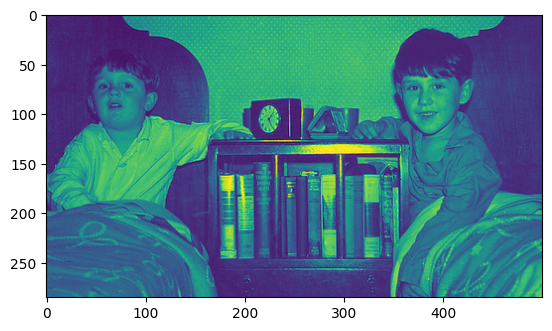

2393892
man  with attributes:  ['smiling']
seat  with attributes:  []
original predicate:  laying on
adversarial predicate:  sitting on
0.004079133737832308
0.07161868363618851


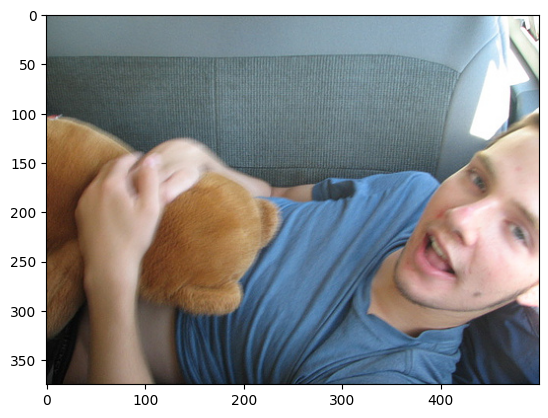

2352889
building  with attributes:  ['white']
pole  with attributes:  []
original predicate:  next to
adversarial predicate:  in front of
7.320011354750022e-05
0.0008485571015626192


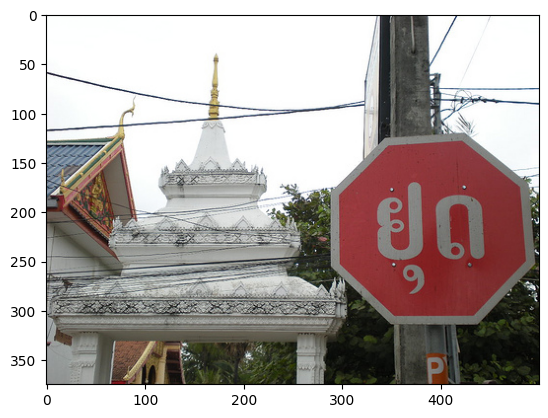

2321841
woman  with attributes:  []
couch  with attributes:  ['brown', 'large', 'leather']
original predicate:  standing next to
adversarial predicate:  above
0.000596617697738111
0.0006892087403684855


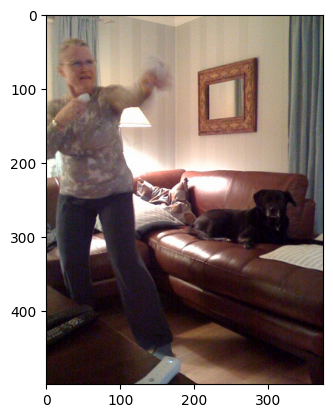

2328306
plant  with attributes:  ['small']
bench  with attributes:  ['wood', 'green', 'wooden', 'green', 'long']
original predicate:  near
adversarial predicate:  next to
0.017160555347800255
0.4945429265499115


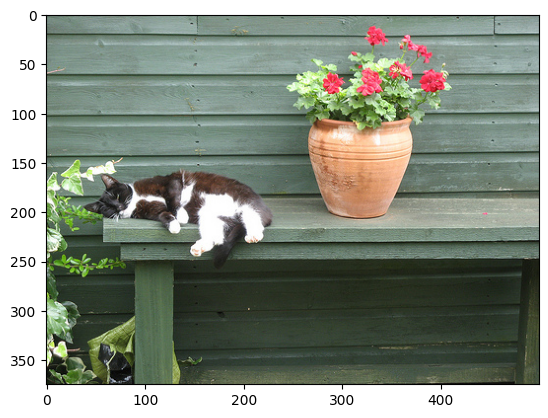

2395196
grass  with attributes:  ['short', 'green']
bench  with attributes:  ['white', 'small', 'brown']
original predicate:  above
adversarial predicate:  in front of
0.0001085819530999288
0.12035258114337921


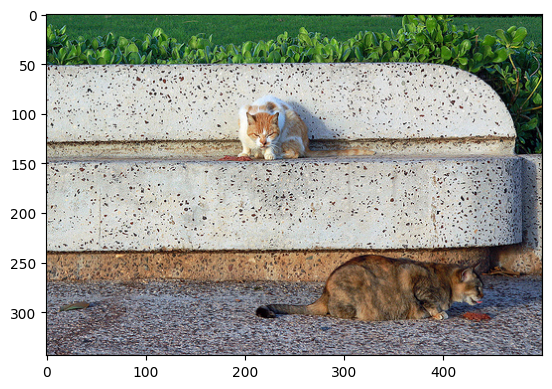

2354003
water  with attributes:  []
glass  with attributes:  ['clear']
original predicate:  on
adversarial predicate:  in
0.07029806077480316
0.8835579752922058


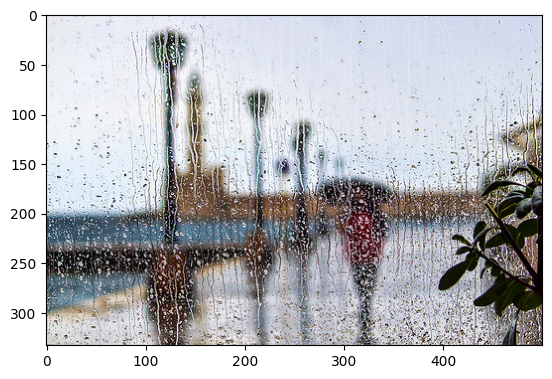

2361236
bush  with attributes:  ['green']
clock  with attributes:  []
original predicate:  beside
adversarial predicate:  behind
0.0001481297513237223
0.9314250946044922


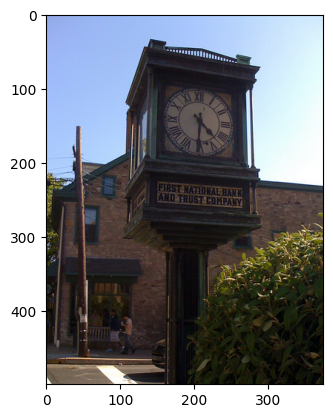

2377356
woman  with attributes:  []
bus  with attributes:  ['white']
original predicate:  near
adversarial predicate:  on
0.05793554708361626
0.2429378181695938


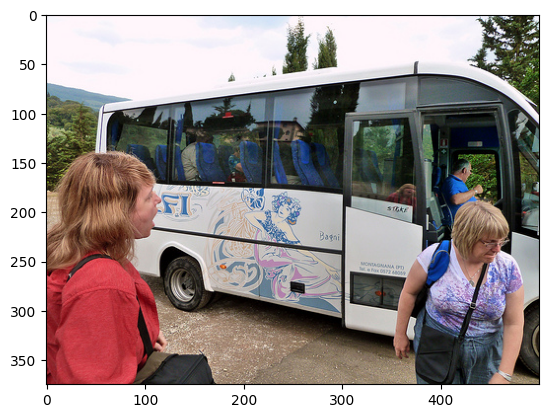

2356554
dog  with attributes:  []
motorcycle  with attributes:  []
original predicate:  near
adversarial predicate:  on
0.0034669667948037386
0.3682660758495331


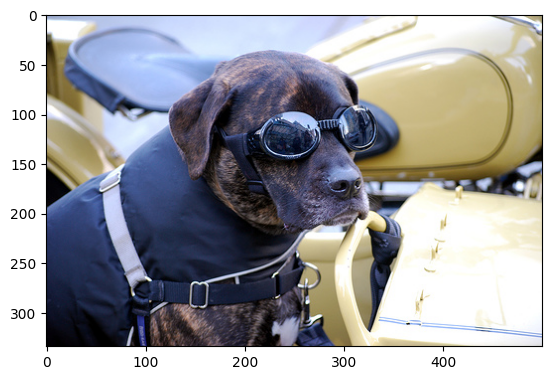

2371105
door  with attributes:  ['wooden']
toilet  with attributes:  ['white']
original predicate:  next to
adversarial predicate:  behind
0.007410489022731781
0.03456433117389679


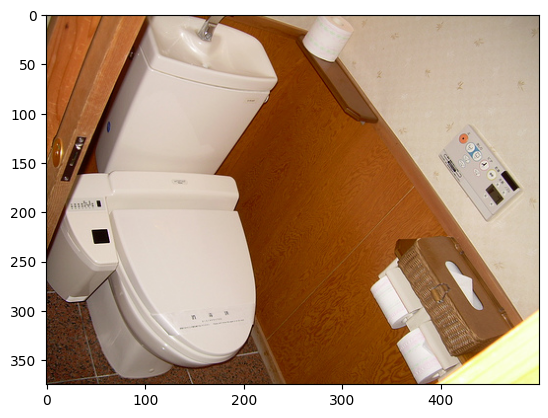

2317779
house  with attributes:  ['small']
field  with attributes:  []
original predicate:  behind
adversarial predicate:  on
0.0404154472053051
0.0841376930475235


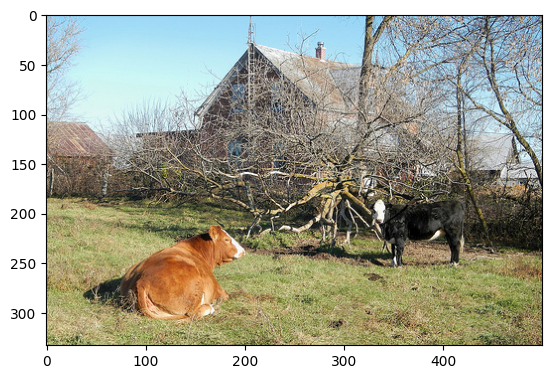

2375277
fence  with attributes:  []
people  with attributes:  []
original predicate:  next to
adversarial predicate:  behind
0.0003815117524936795
0.012894491665065289


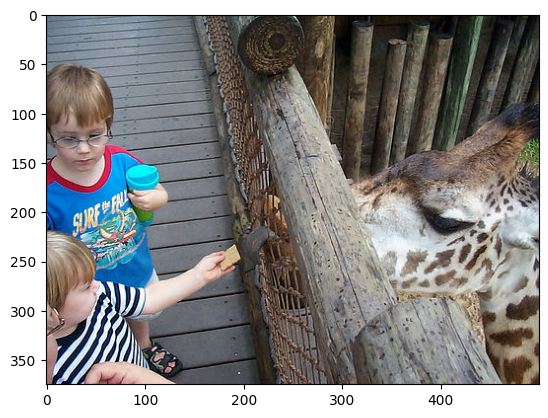

In [27]:
import matplotlib.pyplot as plt
for i,d in enumerate(dataset_v2):
    if i in wrong_indices:
        graph = extract_one_edge_graph(d['original_graph'], d['changed_edge'])
        graph_adv = extract_one_edge_graph(d['adv_graph'], d['changed_edge'])
        print(graph.image_id)
        obj1_name = graph.nodes[list(graph.nodes)[0]]['name']
        obj2_name = graph.nodes[list(graph.nodes)[1]]['name']
        print(obj1_name, " with attributes: ", graph.nodes[list(graph.nodes)[0]]['attributes'])
        print(obj2_name, " with attributes: ", graph.nodes[list(graph.nodes)[1]]['attributes'])
        edge_predicate = graph.edges[list(graph.edges)[0]]['predicate']
        print("original predicate: ", edge_predicate)
        edge_predicate = graph_adv.edges[list(graph_adv.edges)[0]]['predicate']
        print("adversarial predicate: ", edge_predicate)
        try:
            print(scores_orig_v2['rel_scores'][i])
            print(scores_adv_v2['rel_scores'][i])
        except:
            print(scores_orig_v2['overall_scores'][i])
            print(scores_adv_v2['overall_scores'][i])
        # plot the image
        image = get_image(graph.image_id)
        plt.imshow(image)
        plt.show()